In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/xView2_train_images.tar' -C '/content/'

In [ ]:
!ls train
# socal-fire_00001357_post_disaster_target.png
# socal-fire_00001357_pre_disaster_target.png

images	labels	targets


In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
# 파일 경로
label_image_path = '/content/train/targets/guatemala-volcano_00000000_pre_disaster_target.png'

# 이미지 로드
label_image = Image.open(label_image_path)

# 이미지를 numpy 배열로 변환
label_image_array = np.array(label_image)

# 레이블 이미지의 고유값과 분포 시각화
unique, counts = np.unique(label_image_array, return_counts=True)

# 고유값 분포를 프린트
print("Unique pixel values in label image:", unique)
print("Counts for each value:", counts)


Unique pixel values in label image: [0 1]
Counts for each value: [1032725   15851]


In [ ]:
input_dir = 'train/images'
target_dir = 'train/targets'
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

train/images/guatemala-volcano_00000013_pre_disaster.png
train/targets/guatemala-volcano_00000013_pre_disaster_target.png


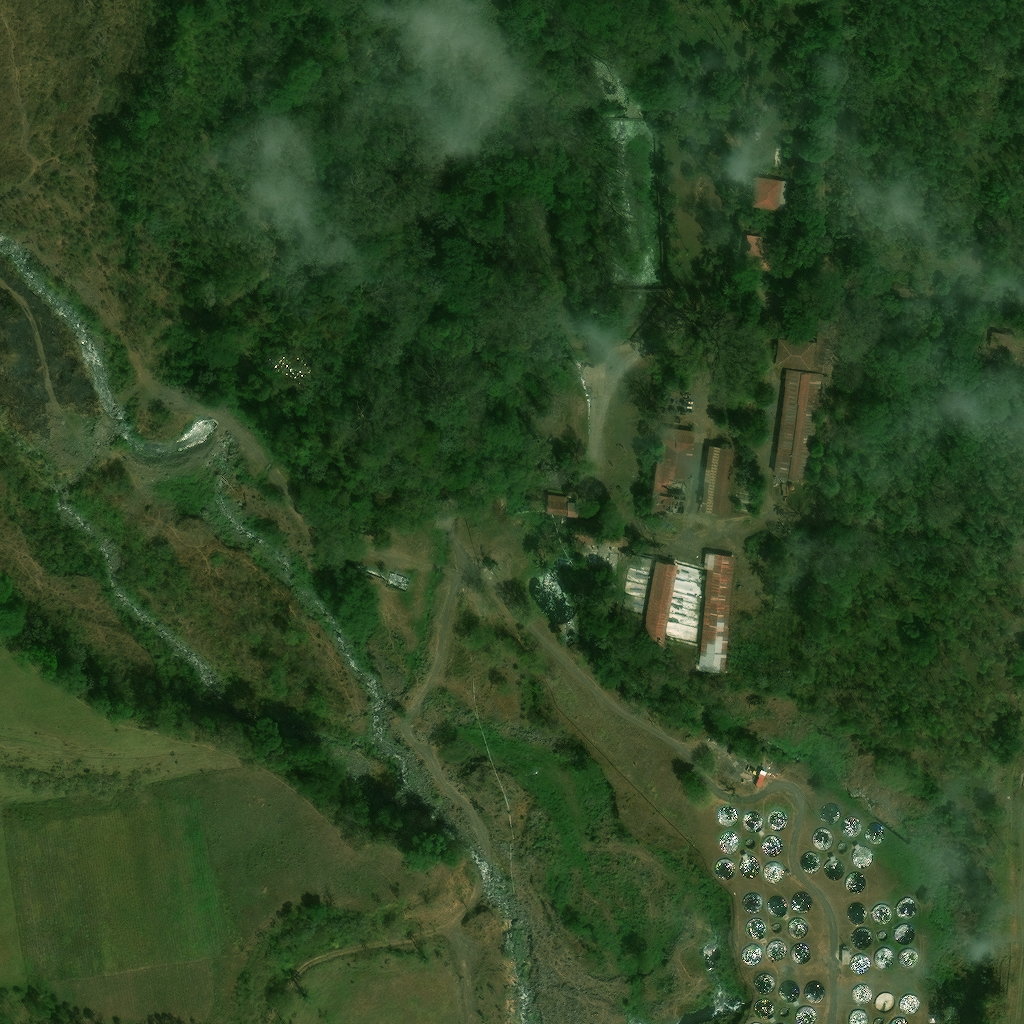

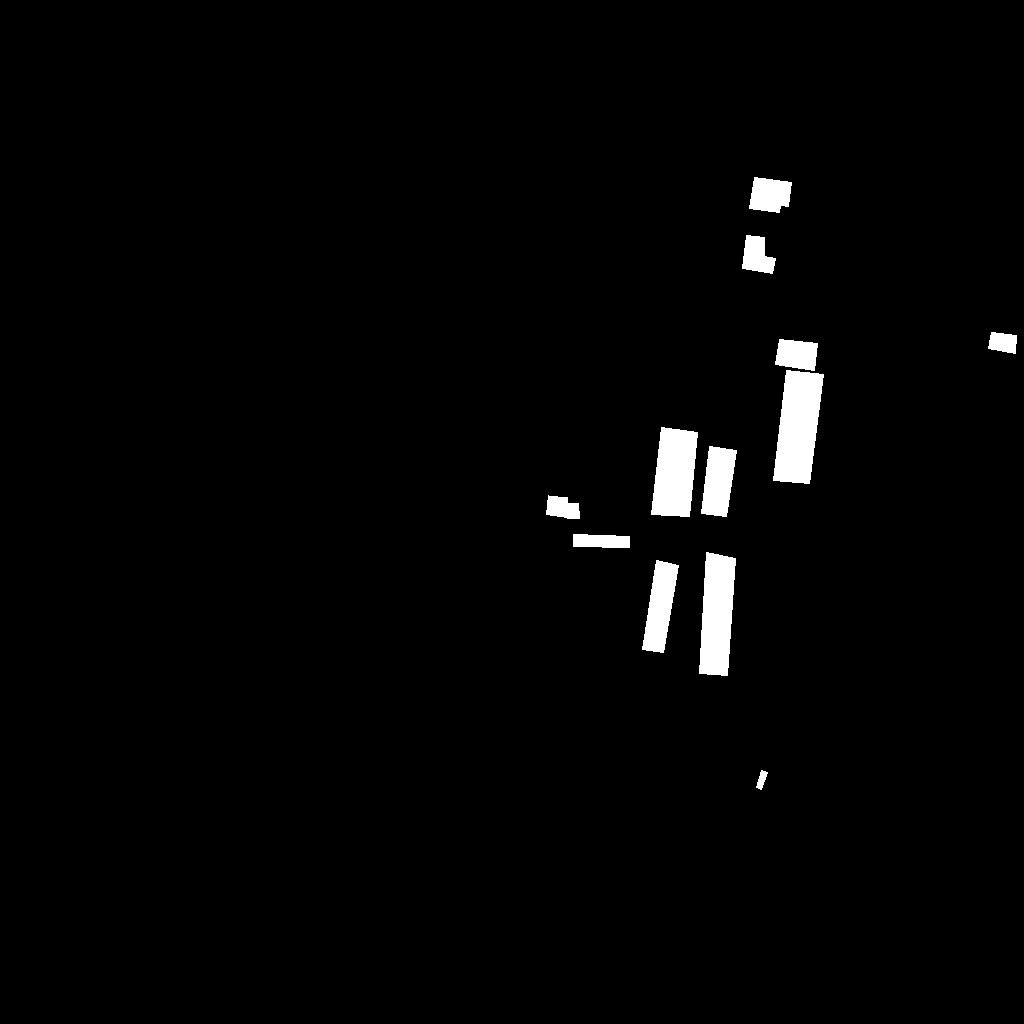

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)
# class0: black class1: white

## 데이터 전처리

In [ ]:
from tensorflow import keras

class xBD(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)

    return x, y


In [ ]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 모델 구성

이진 분류 (sigmoid 사용):

출력 채널 수: 1 (하나의 확률 출력으로, 해당 클래스에 속할 확률을 나타냄)
활성화 함수: sigmoid (0과 1 사이의 값으로 출력을 제한, 이 값이 0.5 이상이면 하나의 클래스로, 그렇지 않으면 다른 클래스로 분류)
이진 분류 (softmax 사용):

출력 채널 수: 2 (두 개의 클래스 각각에 대한 확률을 출력)
활성화 함수: softmax (각 출력값을 확률로 변환하여 모든 클래스에 대한 확률의 합이 1이 되도록 함)
다중 클래스 분류 (softmax 사용):

출력 채널 수: 클래스 수에 해당하는 수
활성화 함수: softmax (위와 동일)

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x

  for filter in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 256, 256, 32)         128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_15

## 모델 학습

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('xbd_segmentation_v5.h5', save_best_only=True)]

epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
1799/1799 [==============================] - ETA: 0s - loss: 0.3413

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1799/1799 [==============================] - 162s 86ms/step - loss: 0.3413 - val_loss: 0.2272
Epoch 2/20
1799/1799 [==============================] - 155s 86ms/step - loss: 0.1405 - val_loss: 0.1871
Epoch 3/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.1128 - val_loss: 0.1289
Epoch 4/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.1050 - val_loss: 0.1529
Epoch 5/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.0932 - val_loss: 7.2503
Epoch 6/20
1799/1799 [==============================] - 154s 85ms/step - loss: 0.0868 - val_loss: 0.1313
Epoch 7/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.0832 - val_loss: 0.3167
Epoch 8/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.0786 - val_loss: 0.1275
Epoch 9/20
1799/1799 [==============================] - 154s 86ms/step - loss: 0.0759 - val_loss: 0.2274
Epoch 10/20
1799/1799 [==============================] - 154s 86ms

## 1. 검증 데이터셋 추론

In [ ]:
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x


In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v5.h5')

In [ ]:
val_gen = xBDInference(batch_size, img_size, val_input_img_paths)
val_predictions = model.predict(val_gen)

1000/1000 [==============================] - 36s 36ms/step


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
# 결과 시각화

def display_mask(i):
  mask = np.argmax(val_predictions[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 1

display(Image(filename=val_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

## 검증용 데이터셋 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/Colab_Notebooks/xBD/val_predicts_v6"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = np.argmax(val_predictions[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")

In [ ]:
# val_predictions 에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(val_predictions)):
    save_mask(i, val_input_img_paths, save_dir)

# 2. 테스트셋 이미지 모델 추론

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v5.h5')

In [ ]:
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/test_images_labels_targets.tar' -C '/content/'

In [ ]:
input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (512, 512)
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test/images/hurricane-florence_00000007_pre_disaster.png
test/targets/hurricane-florence_00000007_pre_disaster_target.png


In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 34s 36ms/step


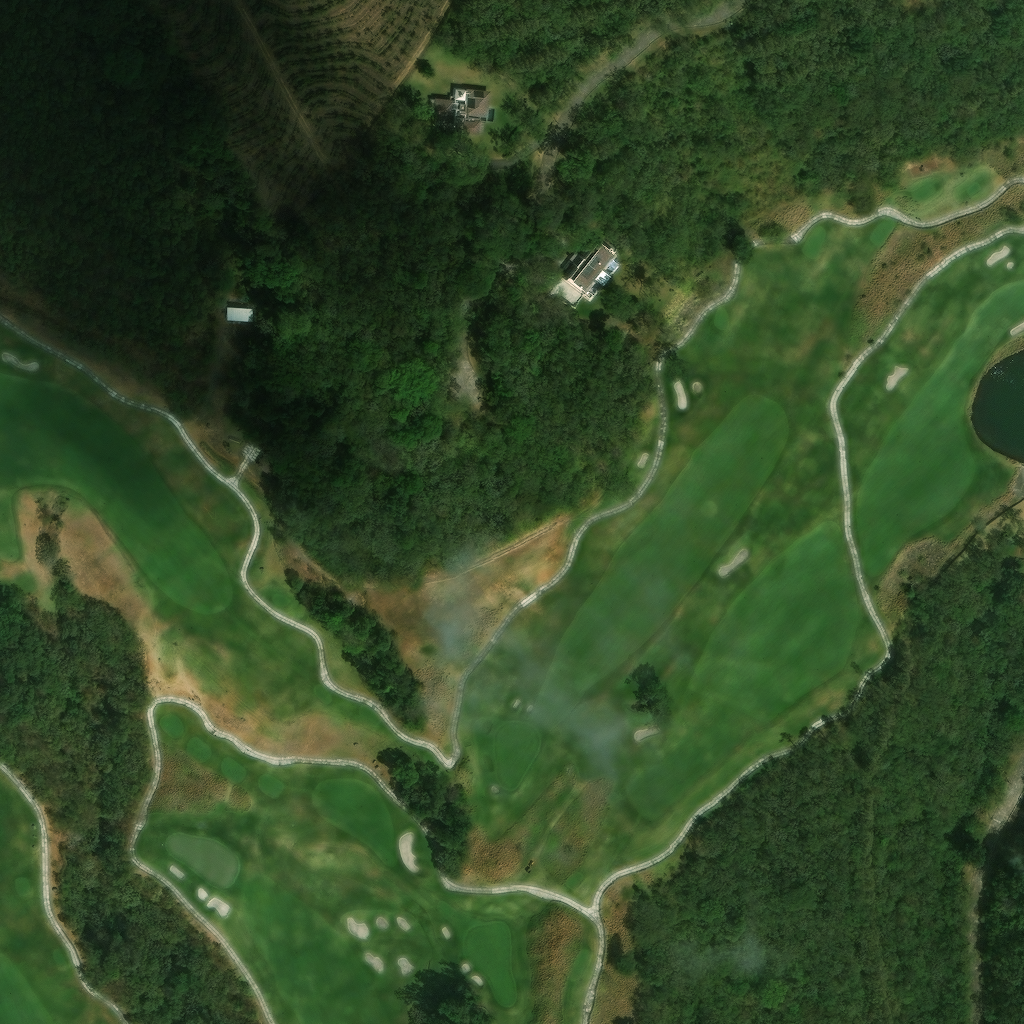

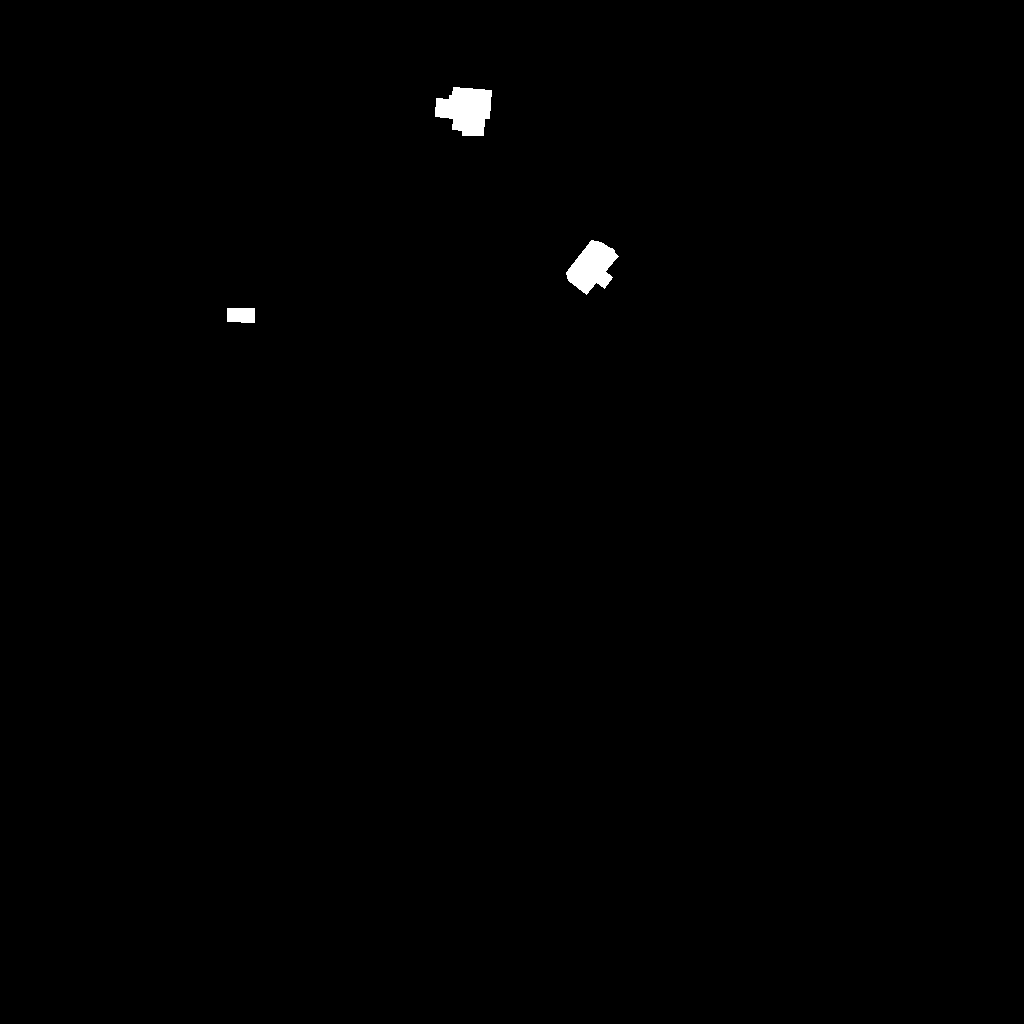

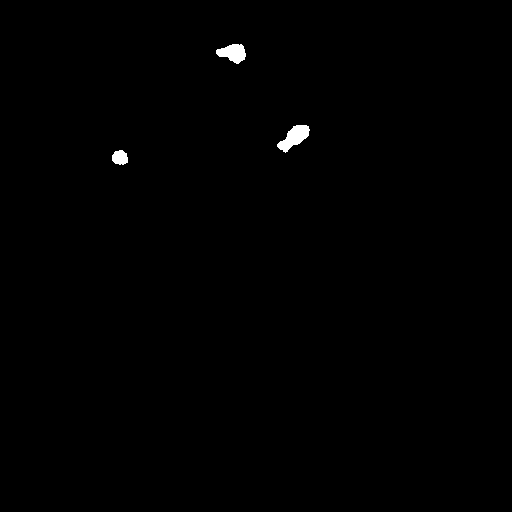

In [ ]:
def display_mask(i):
  mask = np.argmax(test_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 0

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)

## xBD 테스트셋 데이터 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v6"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")

In [ ]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
    save_mask(i, test_input_img_paths, save_dir)

# MIOU 평가 (xBD test Data)

In [ ]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.7209947549828657


# 3. 외부 데이터 추론 (ex. dacon test 이미지)

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v5.h5')

In [ ]:
!unzip -q "/content/drive/MyDrive/실증적 4조 sibas/open.zip" -d "/content"

In [ ]:
input_dir = 'test_img'
img_size = (224, 224)
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.png')
])

test_input_img_paths = input_img_paths[:5000]


In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

5000/5000 [==============================] - 34s 7ms/step


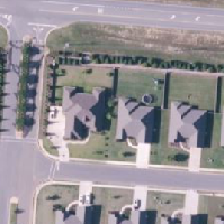

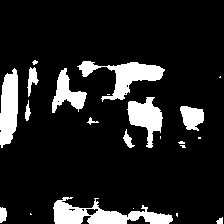

In [ ]:
def display_mask(i):
  mask = np.argmax(test_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 0

display(Image(filename=test_input_img_paths[i]))
display_mask(i)

## Dacon 인공위성 test 이미지 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/Colab_Notebooks/dacon/test_predicts_v6"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")


In [ ]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
    save_mask(i, test_input_img_paths, save_dir)